#### app.py

In [ ]:
import io, streamlit as st, polars as pl, plotly.graph_objects as go
from plotly_resampler import FigureResampler
from dateutil import parser

st.set_page_config(page_title="Ecozimut Dashboard", layout="wide")

PAS = {"30 s": "30s", "1 min": "1m", "5 min": "5m", "10 min": "10m", "15 min": "15m", "30 min": "30m", "1 h": "1h"}
MEAS = {"CO2", "T", "HR"}

# ───────────────– lecture & normalisation ────────────────
def fallback_parse(ts: str):
    """Essaie de convertir n’importe quelle chaîne en datetime ; renvoie None si échec."""
    try:
        return parser.parse(ts, dayfirst=True)
    except Exception:
        return None

def load_file(up) -> pl.DataFrame | None:
    raw = up.read()
    is_xls = up.name.lower().endswith((".xls", ".xlsx","xlsx2csv"))
    sep = ";" if (not is_xls and b";" in raw.splitlines()[0]) else ","

    df = (pl.read_excel(io.BytesIO(raw), sheet_name=0) if is_xls else
          pl.read_csv(io.BytesIO(raw), separator=sep, encoding="latin1",
                      truncate_ragged_lines=True))

    cols = set(df.columns)

    # ── gestion date / heure
    if {"date", "h"}.issubset(cols):
        df = df.with_columns(
            (pl.col("date").cast(pl.Utf8) + " " +
             pl.col("h").cast(pl.Utf8)).alias("datetime")
        )
    elif "date" in cols:
        df = df.rename({"date": "datetime"})
    else:
        st.error(f"{up.name} → colonne 'date' (et optionnel 'h') introuvable.")
        return None

    # ── contrôle des mesures
    missing = MEAS - cols
    if missing:
        st.error(f"{up.name} → colonnes manquantes : {', '.join(missing)}")
        return None

    # ── typage robuste de la datetime
    dt_candidates = [
        pl.col("datetime").str.strptime(pl.Datetime, "%d/%m/%Y %H:%M:%S", strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%d/%m/%Y %H:%M",     strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%d-%m-%Y %H:%M:%S", strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%d-%m-%Y %H:%M",     strict=False),
        pl.col("datetime").map_elements(fallback_parse, return_dtype=pl.Datetime)  # secours Python
    ]

    df = (df
      .with_columns(
          pl.coalesce(dt_candidates).alias("datetime"),
          pl.col("CO2").str.replace(",", ".").cast(pl.Float64),
          pl.col("T").str.replace(",", ".").cast(pl.Float64),
          pl.col("HR").str.replace(",", ".").cast(pl.Float64),
          pl.lit(up.name).alias("sensor")
      )
      .select(["datetime", "CO2", "T", "HR", "sensor"])
      .drop_nulls("datetime"))

    if df.height == 0:
        st.error(f"{up.name} → aucune ligne valide après traitement.")
        return None
    return df

# ───────────────– interface Streamlit ────────────────
st.title("📈 Ecozimut Dashboard : Visualisation de données des sondes de mesures ")

uploads = st.file_uploader(
    "Déposez vos fichiers CSV / Excel :",
    type=["csv", "xlsx", "xls"], accept_multiple_files=True)

if not uploads:
    st.stop()

frames = [d for f in uploads if (d := load_file(f)) is not None]
if not frames:
    st.stop()

data = pl.concat(frames).sort("datetime")

pas_lbl = st.sidebar.selectbox("Pas temporel :", list(PAS.keys()), 1)
bucket = PAS[pas_lbl]

agg = (data
       .groupby_dynamic("datetime", every=bucket, by="sensor", closed="left",
        start_by="datapoint")
       .agg(pl.col("CO2").mean().alias("CO2"),
            pl.col("T").mean().alias("Température"),
            pl.col("HR").mean().alias("Humidité"))
       .sort("datetime"))

sensors = agg["sensor"].unique().to_list()
sel_sensors = st.sidebar.multiselect("Sondes :", sensors, sensors )
vars_ = st.sidebar.multiselect("Variables :", ["CO2", "Température", "Humidité"], [])

plot_df = agg.filter(pl.col("sensor").is_in(sel_sensors))

# ───── Utilisation de session_state pour garder les couleurs personnalisées ─────
if "color_map" not in st.session_state:
    st.session_state.color_map = {}

default_palette = ["#1f77b4", "#ff7f0e", "#2ca02c",
                   "#d62728", "#9467bd", "#8c564b",
                   "#e377c2", "#7f7f7f", "#17becf", "#bcbd22"]

with st.sidebar.expander("🎨 Couleurs des courbes", expanded=False):
    idx = 0
    for v in vars_:
        for s in sel_sensors:
            key = f"{s} – {v}"
            # Utiliser `st.session_state` pour conserver l'état de chaque couleur
            st.session_state.color_map[key] = st.color_picker(
                key,
                value=st.session_state.color_map.get(key, default_palette[idx % len(default_palette)])
            )
            idx += 1

# ───── Tracé du graphique avec les couleurs dynamiques ─────
fig = go.Figure()
for v in vars_:
    for s in sel_sensors:
        sub = plot_df.filter(pl.col("sensor") == s)
        trace_name = f"{s} – {v}"
        fig.add_trace(
            go.Scattergl(
                x=sub["datetime"],
                y=sub[v],
                name=trace_name,
                mode="lines",
                line=dict(color=st.session_state.color_map[trace_name])  # Utiliser la couleur choisie
            )
        )

fig.update_layout(title=f"Courbes (pas {pas_lbl})", height=600, xaxis_title="Date/heure", yaxis_title="Valeur")
fig_rs = FigureResampler(fig)  # instancie le wrapper
st.plotly_chart(fig_rs, use_container_width=True)

st.download_button("Télécharger CSV agrégé",
                   data=agg.write_csv(), file_name=f"agg_{bucket}.csv")



### docker-compose.yml

version: "3.9"
services:
  iaq:
    build: .
    container_name: iaq_dashboard
    # Volume optionnel si tu veux persister des fichiers (non obligatoire)
    volumes:
      - ./data:/app/data
    ports:
      - "8501:8501"
    restart: unless-stopped


### Dockerfile

FROM python:3.11-slim

# Dépendances système minimales
RUN apt-get update && apt-get install -y --no-install-recommends \
    gcc build-essential && \
    rm -rf /var/lib/apt/lists/*

WORKDIR /app
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copie du code
COPY app.py .
EXPOSE 8501

CMD ["streamlit", "run", "app.py", \
     "--server.address", "0.0.0.0", \
     "--server.port", "8501"]


### requirement

streamlit==1.34.*
polars==0.20.*
pyarrow>=15.0
plotly>=5.21
plotly-resampler>=0.10

### schema.yml

# ATTENTION : valeurs des clés = noms EXACTS dans les fichiers bruts

rosa_bonheur:
  engine: csv
  delimiter: ";"
  decimal: ","
  datetime_col: "Time"
  datetime_fmt: "%d/%m/%Y %H:%M"
  columns:
    co2: "CO2"
    temp: "T°"
    rh: "Humidité"

woehler_cdl:                # fichiers “Sonde Wöhler ... .csv”
  engine: csv
  delimiter: ";"
  decimal: ","
  # Les 7 lignes de tête varient → on coupe jusqu’à la bonne
  skip_until: "Date;Heure"
  header_regex: "Date;Heure"
  datetime_merge: ["Date", "Heure"]
  datetime_fmt: "%d/%m/%Y %H:%M:%S"
  columns:
    co2: "CO2"
    temp: "Température"
    rh: "Humidité"

# ➜ Ajouter une section par nouveau constructeur
#   engine: csv | xlsx
#   delimiter / decimal utiles seulement pour CSV
#   datetime_fmt = strptime (python strftime)


### .dockerignore

*.pyc
__pycache__/
data/
.parquet/
.env


In [1]:
%pip install xlsx2csv

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# ---------------------------------------------------------------
# IAQ Dashboard – courbes brutes, colonnes numériques dynamiques
#   • pas d’agrégation temporelle
#   • concaténation robuste même si les colonnes diffèrent
#   • color_picker par trace mémorisé dans st.session_state
# ---------------------------------------------------------------
import io, streamlit as st, polars as pl, plotly.graph_objects as go
from plotly_resampler import FigureResampler
from dateutil import parser
from plotly.subplots import make_subplots


st.set_page_config(page_title="Ecozimut", layout="wide")

# ─────────────────── Fonctions utilitaires ────────────────────
def fallback_parse(ts: str):
    """Essaie de parser n’importe quel timestamp texte → datetime."""
    try:
        return parser.parse(ts, dayfirst=True)
    except Exception:
        return None

def load_file(up) -> pl.DataFrame | None:
    """Lit un fichier CSV/XLSX, renvoie un DF avec datetime, sensor, + colonnes numériques."""
    raw = up.read()
    is_xls = up.name.lower().endswith((".xls", ".xlsx"))
    sep = ";" if (not is_xls and b";" in raw.splitlines()[0]) else ","

    df = (pl.read_excel(io.BytesIO(raw), sheet_name=0) if is_xls else
          pl.read_csv(io.BytesIO(raw), separator=sep, encoding="latin1",
                      truncate_ragged_lines=True))

    cols = set(df.columns)

    # ---- fusion date / h  ----
    if {"date", "h"}.issubset(cols):
        df = df.with_columns(
            (pl.col("date").cast(pl.Utf8) + " " + pl.col("h").cast(pl.Utf8))
            .alias("datetime")
        )
    elif "date" in cols:
        df = df.rename({"date": "datetime"})
    else:
        st.error(f"{up.name} → colonnes 'date' (et optionnel 'h') introuvables.")
        return None

    # ---- conversion datetime robuste ----
    dt = pl.coalesce([
        pl.col("datetime").str.strptime(pl.Datetime, "%d/%m/%Y %H:%M:%S", strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%d/%m/%Y %H:%M",     strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%d-%m-%Y %H:%M:%S", strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%d-%m-%Y %H:%M",     strict=False),
        pl.col("datetime").map_elements(fallback_parse, return_dtype=pl.Datetime)
    ])

    df = df.with_columns(dt.alias("datetime")).drop_nulls("datetime")

    # ---- convertir toutes colonnes numériques possibles ----
    reserved = {"datetime", "date", "h"}
    numeric_cols = []
    for c in df.columns:
        if c in reserved:
            continue
        # remplacer virgules par points → tenter cast Float64
        try:
            df = df.with_columns(
                pl.col(c).cast(pl.Utf8).str.replace(",", ".").cast(pl.Float64, strict=False)
            )
            if df[c].null_count() < df.height:   # au moins une valeur numérique
                numeric_cols.append(c)
        except Exception:
            pass  # ignore les colonnes non convertibles

    if not numeric_cols:
        st.error(f"{up.name} → aucune colonne numérique détectée.")
        return None

    return df.select(["datetime"] + numeric_cols).with_columns(
        pl.lit(up.name).alias("sensor")
    )

# ─────────────────── Interface Streamlit ────────────────────
st.title("📈 Ecozimut Dashboard : Mesures des sondes  ")

uploads = st.file_uploader(
    "Déposez vos CSV / XLSX (date [+ h] + colonnes numériques) :",
    type=["csv", "xlsx", "xls"], accept_multiple_files=True)

if not uploads:
    st.stop()

frames = [d for f in uploads if (d := load_file(f)) is not None]
if not frames:
    st.stop()

# ── 1) union de toutes les colonnes numériques détectées
all_numeric = set()
for df in frames:
    all_numeric |= set(df.columns) - {"datetime", "sensor"}
all_numeric = sorted(all_numeric)       # ordre stable

# ── 2) aligner chaque DF (colonnes manquantes + cast Float64)
aligned = []
for df in frames:
    # ajouter les colonnes manquantes, typées Float64
    miss = [c for c in all_numeric if c not in df.columns]
    if miss:
        df = df.with_columns([
            pl.lit(None).cast(pl.Float64).alias(c) for c in miss
        ])
    # garantir que toutes les colonnes numériques sont Float64
    df = df.with_columns([
        pl.col(c).cast(pl.Float64, strict=False) for c in all_numeric
    ])
    aligned.append(df.select(["datetime", "sensor"] + all_numeric))


# ── 3) concaténation sans ShapeError
data = pl.concat(aligned).sort("datetime")

# widgets
sensors = data["sensor"].unique().to_list()
sel_sensors = st.sidebar.multiselect("Sondes :", sensors, default=sensors)



vars_ = st.sidebar.multiselect("Variables :", all_numeric, default=[])

# on ne gère pour l’instant que deux variables avec axes distincts
if len(vars_) > 2:
    st.sidebar.warning("⚠️ L’outil affiche au maximum 2 variables simultanées.")
    vars_ = vars_[:2]


plot_df = data.filter(pl.col("sensor").is_in(sel_sensors))


# ── réglages d’échelle pour chaque variable sélectionnée
y_ranges = {}
with st.sidebar.expander("🔧 Ajuster les échelles (min / max)", expanded=False):
    for v in vars_:
        col1, col2 = st.columns(2)
        v_min = float(plot_df[v].min())
        v_max = float(plot_df[v].max())
        with col1:
            min_val = st.number_input(f"{v} min", value=v_min, key=f"{v}_min")
        with col2:
            max_val = st.number_input(f"{v} max", value=v_max, key=f"{v}_max")
        # sécurité : si l’utilisateur met min >= max on ignore la saisie
        y_ranges[v] = None if min_val >= max_val else [min_val, max_val]


# ── palette + color_picker mémorisés
if "color_map" not in st.session_state:
    st.session_state.color_map = {}

default_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
                   "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
                   "#17becf", "#bcbd22"]

with st.sidebar.expander("🎨 Couleurs", expanded=False):
    idx = 0
    for v in vars_:
        for s in sel_sensors:
            key = f"{s} – {v}"
            st.session_state.color_map[key] = st.color_picker(
                key,
                value=st.session_state.color_map.get(
                    key, default_palette[idx % len(default_palette)]
                )
            )
            idx += 1

# ────────── Tracé avec axes distincts (gauche/droite) ──────────
fig = make_subplots(specs=[[{"secondary_y": len(vars_) == 2}]])

for idx, v in enumerate(vars_):
    secondary = True if idx == 1 else False   # 2ᵉ variable -> axe droit
    for s in sel_sensors:
        sub = plot_df.filter(pl.col("sensor") == s)
        if sub[v].null_count() == sub.height:
            continue
        trace_name = f"{s} – {v}"
        fig.add_trace(
            go.Scattergl(
                x=sub["datetime"],
                y=sub[v],
                name=trace_name,
                mode="lines",
                line=dict(color=st.session_state.color_map[trace_name])
            ),
            secondary_y=secondary #if len(vars_) == 2 else False
        )

if len(vars_) == 1:
    fig.update_yaxes(title_text=vars_[0])
elif len(vars_) == 2:
    fig.update_yaxes(title_text=vars_[0], secondary_y=False)
    fig.update_yaxes(title_text=vars_[1], secondary_y=True)
else:
    pass

# appliquer les limites min/max si fournies
for idx, v in enumerate(vars_):
    rng = y_ranges.get(v)
    if rng:
        fig.update_yaxes(range=rng, secondary_y=(idx == 1) if len(vars_) == 2 else False)

fig.update_layout(
    title="Courbes brutes",
    height=600,
    xaxis_title="Date/heure"
)

st.plotly_chart(FigureResampler(fig), use_container_width=True)


# ── Export CSV brut
st.download_button("Télécharger CSV concaténé",
                   data=data.write_csv(), file_name="mesures_brutes.csv")


In [4]:
dates_text = """
2023-01-01T00:06:24Z
2023-01-01T00:36:35Z
2023-01-01T01:06:46Z
2023-01-01T01:36:58Z
2023-01-01T02:07:08Z
2023-01-01T02:37:19Z
2023-01-01T03:07:31Z
2023-01-01T03:37:42Z
2023-01-01T04:07:53Z
2023-01-01T04:38:04Z
2023-01-01T05:08:14Z
2023-01-01T05:38:26Z
2023-01-01T06:08:36Z
2023-01-01T06:38:47Z
2023-01-01T07:08:58Z
2023-01-01T07:39:09Z
2023-01-01T08:09:20Z
2023-01-01T08:39:31Z
2023-01-01T09:09:42Z
2023-01-01T09:39:53Z
2023-01-01T10:10:04Z
2023-01-01T10:40:15Z
2023-01-01T11:10:25Z
2023-01-01T11:40:36Z
2023-01-01T12:10:47Z
2023-01-01T12:40:58Z
2023-01-01T13:11:10Z
2023-01-01T13:41:20Z
2023-01-01T14:11:32Z
2023-01-01T14:41:43Z
2023-01-01T15:11:54Z
2023-01-01T15:42:04Z
2023-01-01T16:12:16Z
2023-01-01T16:42:27Z
2023-01-01T17:12:38Z
2023-01-01T17:42:49Z
2023-01-01T18:13:00Z
2023-01-01T18:43:12Z
2023-01-01T19:13:22Z
2023-01-01T19:43:33Z
2023-01-01T20:13:44Z
2023-01-01T20:43:55Z
2023-01-01T21:14:06Z
2023-01-01T21:44:17Z
2023-01-01T22:14:28Z
2023-01-01T22:44:38Z
2023-01-01T23:14:49Z
2023-01-01T23:44:59Z
2023-01-02T00:15:10Z
2023-01-02T00:45:21Z
2023-01-02T01:15:31Z
2023-01-02T01:45:42Z
2023-01-02T02:15:53Z
2023-01-02T02:46:03Z
2023-01-02T03:16:14Z
2023-01-02T03:46:25Z
2023-01-02T04:16:35Z
2023-01-02T04:46:46Z
2023-01-02T05:16:57Z
2023-01-02T05:47:07Z
2023-01-02T06:17:18Z
2023-01-02T06:47:29Z
2023-01-02T07:17:39Z
2023-01-02T07:47:51Z
2023-01-02T08:18:01Z
2023-01-02T08:48:12Z
2023-01-02T09:18:22Z
2023-01-02T09:48:34Z
2023-01-02T10:18:45Z
2023-01-02T10:48:56Z
2023-01-02T11:19:06Z
2023-01-02T11:49:17Z
2023-01-02T12:19:28Z
2023-01-02T12:49:40Z
2023-01-02T13:19:50Z
2023-01-02T13:50:01Z
2023-01-02T14:20:12Z
2023-01-02T14:50:23Z
2023-01-02T15:20:34Z
2023-01-02T15:50:45Z
2023-01-02T16:20:56Z
2023-01-02T16:51:06Z
2023-01-02T17:21:17Z
2023-01-02T17:51:28Z
2023-01-02T18:21:39Z
2023-01-02T18:51:49Z
2023-01-02T19:22:00Z
2023-01-02T19:52:11Z
2023-01-02T20:22:22Z
2023-01-02T20:52:33Z
2023-01-02T21:22:44Z
2023-01-02T21:52:54Z
2023-01-02T22:23:05Z
2023-01-02T22:53:15Z
2023-01-02T23:23:27Z
2023-01-02T23:53:37Z
2023-01-03T00:23:48Z
2023-01-03T00:53:58Z
2023-01-03T01:24:09Z
2023-01-03T01:54:19Z
2023-01-03T02:24:30Z
2023-01-03T02:54:41Z
2023-01-03T03:24:52Z
2023-01-03T03:55:02Z
2023-01-03T04:25:13Z
2023-01-03T04:55:24Z
2023-01-03T05:25:36Z
2023-01-03T05:55:46Z
2023-01-03T06:25:56Z
2023-01-03T06:56:07Z
2023-01-03T07:26:18Z
2023-01-03T07:56:28Z
2023-01-03T08:26:37Z
2023-01-03T08:56:35Z
2023-01-03T09:26:32Z
2023-01-03T09:56:28Z
2023-01-03T10:26:24Z
2023-01-03T10:56:21Z
2023-01-03T11:26:18Z
2023-01-03T11:56:27Z
2023-01-03T12:26:35Z
2023-01-03T12:56:44Z
2023-01-03T13:26:59Z
2023-01-03T13:56:56Z
2023-01-03T14:26:45Z
2023-01-03T14:56:49Z
2023-01-03T15:26:45Z
2023-01-03T15:56:52Z
2023-01-03T16:26:56Z
2023-01-03T16:56:59Z
2023-01-03T17:27:05Z
2023-01-03T17:57:08Z
2023-01-03T18:27:13Z
2023-01-03T18:57:19Z
2023-01-03T19:27:23Z
2023-01-03T19:57:28Z
2023-01-03T20:27:33Z
2023-01-03T20:57:39Z
2023-01-03T21:27:44Z
2023-01-03T21:57:49Z
2023-01-03T22:27:55Z
2023-01-03T22:58:02Z
2023-01-03T23:28:12Z
2023-01-03T23:58:22Z
2023-01-04T00:28:33Z
2023-01-04T00:58:43Z
2023-01-04T01:28:53Z
2023-01-04T01:59:04Z
2023-01-04T02:29:14Z
2023-01-04T02:59:25Z
2023-01-04T03:29:35Z
2023-01-04T03:59:46Z
2023-01-04T04:29:57Z
2023-01-04T05:00:09Z
2023-01-04T05:30:20Z
2023-01-04T06:00:31Z
2023-01-04T06:30:42Z
2023-01-04T07:00:53Z
2023-01-04T07:31:03Z
2023-01-04T08:01:14Z
2023-01-04T08:31:31Z
2023-01-04T09:01:29Z
2023-01-04T09:31:26Z
2023-01-04T10:01:23Z
2023-01-04T10:31:21Z
2023-01-04T11:01:18Z
2023-01-04T11:31:21Z
2023-01-04T12:01:19Z
2023-01-04T12:31:17Z
2023-01-04T13:01:16Z
2023-01-04T13:31:14Z
2023-01-04T14:01:12Z
2023-01-04T14:31:11Z
2023-01-04T15:01:10Z
2023-01-04T15:31:09Z
2023-01-04T16:01:07Z
2023-01-04T16:31:07Z
2023-01-04T17:01:05Z
2023-01-04T17:31:10Z
2023-01-04T18:01:17Z
2023-01-04T18:31:23Z
2023-01-04T19:01:29Z
2023-01-04T19:31:35Z
2023-01-04T20:01:42Z
2023-01-04T20:31:49Z
2023-01-04T21:01:55Z
2023-01-04T21:32:01Z
2023-01-04T22:02:08Z
2023-01-04T22:32:15Z
2023-01-04T23:02:28Z
2023-01-04T23:32:33Z
2023-01-05T00:02:39Z
2023-01-05T00:32:50Z
2023-01-05T01:03:01Z
2023-01-05T01:33:11Z
2023-01-05T02:03:22Z
2023-01-05T02:33:32Z
2023-01-05T03:03:42Z
2023-01-05T03:33:54Z
2023-01-05T04:04:04Z
2023-01-05T04:34:15Z
2023-01-05T05:04:26Z
2023-01-05T05:34:36Z
2023-01-05T06:04:48Z
2023-01-05T06:34:58Z
2023-01-05T07:05:09Z
2023-01-05T07:35:19Z
2023-01-05T08:05:31Z
2023-01-05T08:35:37Z
2023-01-05T09:05:36Z
2023-01-05T09:35:33Z
2023-01-05T10:05:29Z
2023-01-05T10:35:26Z
2023-01-05T11:05:22Z
2023-01-05T11:35:27Z
2023-01-05T12:05:24Z
2023-01-05T12:35:22Z
2023-01-05T13:05:18Z
2023-01-05T13:35:15Z
2023-01-05T14:05:12Z
2023-01-05T14:35:08Z
2023-01-05T15:04:58Z
2023-01-05T15:34:52Z
2023-01-05T16:05:00Z
2023-01-05T16:35:09Z
2023-01-05T17:05:18Z
2023-01-05T17:35:27Z
2023-01-05T18:05:35Z
2023-01-05T18:35:45Z
2023-01-05T19:05:54Z
2023-01-05T19:36:04Z
2023-01-05T20:06:16Z
2023-01-05T20:36:22Z
2023-01-05T21:06:32Z
2023-01-05T21:36:42Z
2023-01-05T22:06:52Z
2023-01-05T22:37:02Z
2023-01-05T23:07:12Z
2023-01-05T23:37:22Z
2023-01-06T00:07:33Z
2023-01-06T00:37:45Z
2023-01-06T01:07:55Z
2023-01-06T01:38:06Z
2023-01-06T02:08:17Z
2023-01-06T02:38:28Z
2023-01-06T03:08:40Z
2023-01-06T03:38:50Z
2023-01-06T04:09:01Z
2023-01-06T04:39:12Z
2023-01-06T05:09:23Z
2023-01-06T05:39:34Z
2023-01-06T06:09:45Z
2023-01-06T06:39:55Z
2023-01-06T07:10:05Z
2023-01-06T07:40:16Z
2023-01-06T08:10:26Z
2023-01-06T08:40:32Z
2023-01-06T09:10:30Z
2023-01-06T09:40:28Z
2023-01-06T10:10:24Z
2023-01-06T10:40:23Z
2023-01-06T11:10:19Z
2023-01-06T11:40:16Z
2023-01-06T12:10:13Z
2023-01-06T12:40:11Z
2023-01-06T13:10:09Z
2023-01-06T13:40:06Z
2023-01-06T14:10:03Z
2023-01-06T14:40:00Z
2023-01-06T15:10:04Z
2023-01-06T15:39:58Z
2023-01-06T16:10:07Z
2023-01-06T16:40:15Z
2023-01-06T17:10:25Z
2023-01-06T17:40:34Z
2023-01-06T18:10:44Z
2023-01-06T18:40:54Z
2023-01-06T19:11:04Z
2023-01-06T19:41:14Z
2023-01-06T20:11:24Z
2023-01-06T20:41:35Z
2023-01-06T21:11:46Z
2023-01-06T21:41:57Z
2023-01-06T22:12:08Z
2023-01-06T22:42:19Z
2023-01-06T23:12:30Z
2023-01-06T23:42:41Z
2023-01-07T00:12:52Z
2023-01-07T00:43:04Z
2023-01-07T01:13:16Z
2023-01-07T01:43:28Z
2023-01-07T02:13:39Z
2023-01-07T02:43:51Z
2023-01-07T03:14:02Z
2023-01-07T03:44:14Z
2023-01-07T04:14:26Z
2023-01-07T04:44:37Z
2023-01-07T05:14:49Z
2023-01-07T05:44:59Z
2023-01-07T06:15:11Z
2023-01-07T06:45:22Z
2023-01-07T07:15:32Z
2023-01-07T07:45:44Z
2023-01-07T08:15:55Z
2023-01-07T08:46:05Z
2023-01-07T09:16:17Z
2023-01-07T09:46:27Z
2023-01-07T10:16:37Z
2023-01-07T10:46:47Z
2023-01-07T11:16:57Z
2023-01-07T11:47:07Z
2023-01-07T12:17:18Z
2023-01-07T12:47:28Z
2023-01-07T13:17:38Z
2023-01-07T13:47:48Z
2023-01-07T14:17:59Z
2023-01-07T14:48:09Z
2023-01-07T15:18:20Z
2023-01-07T15:48:30Z
2023-01-07T16:18:41Z
2023-01-07T16:48:52Z
2023-01-07T17:19:02Z
2023-01-07T17:49:13Z
2023-01-07T18:19:25Z
2023-01-07T18:49:36Z
2023-01-07T19:19:47Z
2023-01-07T19:49:58Z
2023-01-07T20:20:09Z
2023-01-07T20:50:20Z
2023-01-07T21:20:32Z
2023-01-07T21:50:43Z
2023-01-07T22:20:54Z
2023-01-07T22:51:05Z
2023-01-07T23:21:17Z
2023-01-07T23:51:28Z
2023-01-08T00:21:39Z
2023-01-08T00:51:50Z
2023-01-08T01:22:00Z
2023-01-08T01:52:11Z
2023-01-08T02:22:22Z
2023-01-08T02:52:32Z
2023-01-08T03:22:43Z
2023-01-08T03:52:54Z
2023-01-08T04:23:04Z
2023-01-08T04:53:16Z
2023-01-08T05:23:26Z
2023-01-08T05:53:37Z
2023-01-08T06:23:47Z
2023-01-08T06:53:58Z
2023-01-08T07:24:09Z
2023-01-08T07:54:21Z
2023-01-08T08:24:31Z
2023-01-08T08:54:43Z
2023-01-08T09:24:53Z
2023-01-08T09:55:04Z
2023-01-08T10:25:15Z
2023-01-08T10:55:25Z
2023-01-08T11:25:36Z
2023-01-08T11:55:46Z
2023-01-08T12:25:57Z
2023-01-08T12:56:07Z
2023-01-08T13:26:18Z
2023-01-08T13:56:28Z
2023-01-08T14:26:39Z
2023-01-08T14:56:50Z
2023-01-08T15:27:00Z
2023-01-08T15:57:10Z
2023-01-08T16:27:22Z
2023-01-08T16:57:33Z
2023-01-08T17:27:43Z
2023-01-08T17:57:53Z
2023-01-08T18:28:04Z
2023-01-08T18:58:15Z
2023-01-08T19:28:26Z
2023-01-08T19:58:37Z
2023-01-08T20:28:47Z
2023-01-08T20:58:58Z
2023-01-08T21:29:09Z
2023-01-08T21:59:19Z
2023-01-08T22:29:31Z
2023-01-08T22:59:41Z
2023-01-08T23:29:52Z
2023-01-09T00:00:03Z
2023-01-09T00:30:15Z
2023-01-09T01:00:25Z
2023-01-09T01:30:36Z
2023-01-09T02:00:47Z
2023-01-09T02:30:58Z
2023-01-09T03:01:08Z
2023-01-09T03:31:19Z
2023-01-09T04:01:30Z
2023-01-09T04:31:40Z
2023-01-09T05:01:51Z
2023-01-09T05:32:02Z
2023-01-09T06:02:13Z
2023-01-09T06:32:24Z
2023-01-09T07:02:36Z
2023-01-09T07:32:47Z
2023-01-09T08:02:58Z
2023-01-09T08:33:07Z
2023-01-09T09:03:06Z
2023-01-09T09:33:12Z
2023-01-09T10:03:03Z
2023-01-09T10:33:09Z
2023-01-09T11:03:06Z
2023-01-09T11:33:04Z
2023-01-09T12:03:02Z
2023-01-09T12:33:12Z
2023-01-09T13:03:22Z
2023-01-09T13:33:35Z
2023-01-09T14:03:32Z
2023-01-09T14:33:30Z
2023-01-09T15:03:27Z
2023-01-09T15:33:24Z
2023-01-09T16:03:20Z
2023-01-09T16:33:28Z
2023-01-09T17:03:31Z
2023-01-09T17:33:37Z
2023-01-09T18:03:42Z
2023-01-09T18:33:53Z
2023-01-09T19:04:03Z
2023-01-09T19:34:13Z
2023-01-09T20:04:23Z
2023-01-09T20:34:33Z
2023-01-09T21:04:44Z
2023-01-09T21:34:54Z
2023-01-09T22:05:05Z
2023-01-09T22:35:15Z
2023-01-09T23:05:26Z
2023-01-09T23:35:38Z
2023-01-10T00:05:48Z
2023-01-10T00:35:59Z
2023-01-10T01:06:10Z
2023-01-10T01:36:19Z
2023-01-10T02:06:30Z
2023-01-10T02:36:41Z
2023-01-10T03:06:51Z
2023-01-10T03:37:01Z
2023-01-10T04:07:12Z
2023-01-10T04:37:23Z
2023-01-10T05:07:33Z
2023-01-10T05:37:45Z
2023-01-10T06:07:55Z
2023-01-10T06:38:06Z
2023-01-10T07:08:17Z
2023-01-10T07:38:28Z
2023-01-10T08:08:39Z
2023-01-10T08:38:52Z
2023-01-10T09:08:51Z
2023-01-10T09:38:48Z
2023-01-10T10:08:46Z
2023-01-10T10:38:43Z
2023-01-10T11:08:40Z
2023-01-10T11:38:44Z
2023-01-10T12:08:53Z
2023-01-10T12:39:02Z
2023-01-10T13:09:11Z
2023-01-10T13:39:16Z
2023-01-10T14:09:12Z
2023-01-10T14:39:09Z
2023-01-10T15:09:21Z
2023-01-10T15:39:07Z
2023-01-10T16:09:15Z
2023-01-10T16:39:24Z
2023-01-10T17:09:32Z
2023-01-10T17:39:40Z
2023-01-10T18:09:49Z
2023-01-10T18:39:58Z
2023-01-10T19:10:07Z
2023-01-10T19:40:18Z
2023-01-10T20:10:27Z
2023-01-10T20:40:37Z
2023-01-10T21:10:46Z
2023-01-10T21:40:56Z
2023-01-10T22:11:05Z
2023-01-10T22:41:16Z
2023-01-10T23:11:26Z
2023-01-10T23:41:36Z
2023-01-11T00:11:47Z
2023-01-11T00:41:57Z
2023-01-11T01:12:07Z
2023-01-11T01:42:18Z
2023-01-11T02:12:29Z
2023-01-11T02:42:40Z
2023-01-11T03:12:51Z
2023-01-11T03:43:01Z
2023-01-11T04:13:12Z
2023-01-11T04:43:23Z
2023-01-11T05:13:33Z
2023-01-11T05:43:44Z
2023-01-11T06:13:55Z
2023-01-11T06:44:05Z
2023-01-11T07:14:16Z
2023-01-11T07:44:27Z
2023-01-11T08:14:38Z
2023-01-11T08:44:44Z
2023-01-11T09:14:42Z
2023-01-11T09:44:41Z
2023-01-11T10:14:37Z
2023-01-11T10:44:36Z
2023-01-11T11:14:32Z
2023-01-11T11:44:29Z
2023-01-11T12:14:28Z
2023-01-11T12:44:25Z
2023-01-11T13:14:24Z
2023-01-11T13:44:22Z
2023-01-11T14:14:21Z
2023-01-11T14:44:20Z
2023-01-11T15:14:19Z
2023-01-11T15:44:18Z
2023-01-11T16:14:17Z
2023-01-11T16:44:15Z
2023-01-11T17:14:21Z
2023-01-11T17:44:28Z
2023-01-11T18:14:34Z
2023-01-11T18:44:41Z
2023-01-11T19:14:47Z
2023-01-11T19:44:54Z
2023-01-11T20:15:01Z
2023-01-11T20:45:05Z
2023-01-11T21:15:19Z
2023-01-11T21:45:30Z
2023-01-11T22:15:35Z
2023-01-11T22:45:47Z
2023-01-11T23:15:58Z
2023-01-11T23:46:09Z
2023-01-12T00:16:20Z
2023-01-12T00:46:31Z
2023-01-12T01:16:41Z
2023-01-12T01:46:52Z
2023-01-12T02:17:02Z
2023-01-12T02:47:14Z
2023-01-12T03:17:24Z
2023-01-12T03:47:35Z
2023-01-12T04:17:46Z
2023-01-12T04:47:57Z
2023-01-12T05:18:09Z
2023-01-12T05:48:19Z
2023-01-12T06:18:29Z
2023-01-12T06:48:40Z
2023-01-12T07:18:51Z
2023-01-12T07:49:02Z
2023-01-12T08:19:14Z
2023-01-12T08:49:20Z
2023-01-12T09:19:17Z
2023-01-12T09:49:14Z
2023-01-12T10:19:03Z
2023-01-12T10:49:17Z
2023-01-12T11:19:17Z
2023-01-12T11:49:16Z
2023-01-12T12:19:24Z
2023-01-12T12:49:33Z
2023-01-12T13:19:44Z
2023-01-12T13:49:41Z
2023-01-12T14:19:45Z
2023-01-12T14:49:56Z
2023-01-12T15:19:53Z
2023-01-12T15:49:57Z
2023-01-12T16:20:06Z
2023-01-12T16:50:14Z
2023-01-12T17:20:22Z
2023-01-12T17:50:31Z
2023-01-12T18:20:41Z
2023-01-12T18:50:51Z
2023-01-12T19:21:00Z
2023-01-12T19:51:10Z
2023-01-12T20:21:19Z
2023-01-12T20:51:29Z
2023-01-12T21:21:39Z
2023-01-12T21:51:49Z
2023-01-12T22:21:59Z
2023-01-12T22:52:09Z
2023-01-12T23:22:19Z
2023-01-12T23:52:29Z
2023-01-13T00:22:39Z
2023-01-13T00:52:49Z
2023-01-13T01:23:00Z
2023-01-13T01:53:10Z
2023-01-13T02:23:21Z
2023-01-13T02:53:32Z
2023-01-13T03:23:43Z
2023-01-13T03:53:53Z
2023-01-13T04:24:04Z
2023-01-13T04:54:14Z
2023-01-13T05:24:25Z
2023-01-13T05:54:36Z
2023-01-13T06:24:47Z
2023-01-13T06:54:57Z
2023-01-13T07:25:08Z
2023-01-13T07:55:18Z
2023-01-13T08:25:28Z
2023-01-13T08:55:26Z
2023-01-13T09:25:24Z
2023-01-13T09:55:21Z
2023-01-13T10:25:17Z
2023-01-13T10:55:14Z
2023-01-13T11:25:10Z
2023-01-13T11:55:06Z
2023-01-13T12:25:03Z
2023-01-13T12:55:00Z
2023-01-13T13:25:05Z
2023-01-13T13:55:02Z
2023-01-13T14:24:58Z
2023-01-13T14:54:54Z
2023-01-13T15:24:42Z
2023-01-13T15:54:51Z
2023-01-13T16:24:55Z
2023-01-13T16:54:58Z
2023-01-13T17:25:01Z
2023-01-13T17:55:05Z
2023-01-13T18:25:09Z
2023-01-13T18:55:14Z
2023-01-13T19:25:18Z
2023-01-13T19:55:21Z
2023-01-13T20:25:30Z
2023-01-13T20:55:39Z
2023-01-13T21:25:48Z
2023-01-13T21:55:58Z
2023-01-13T22:26:07Z
2023-01-13T22:56:17Z
2023-01-13T23:26:27Z
2023-01-13T23:56:37Z
2023-01-14T00:26:47Z
2023-01-14T00:56:58Z
2023-01-14T01:27:08Z
2023-01-14T01:57:19Z
2023-01-14T02:27:31Z
2023-01-14T02:57:41Z
2023-01-14T03:27:52Z
2023-01-14T03:58:03Z
2023-01-14T04:28:14Z
2023-01-14T04:58:25Z
2023-01-14T05:28:37Z
2023-01-14T05:58:47Z
2023-01-14T06:28:59Z
2023-01-14T06:59:10Z
2023-01-14T07:29:22Z
2023-01-14T07:59:33Z
2023-01-14T08:29:44Z
2023-01-14T08:59:55Z
2023-01-14T09:30:05Z
2023-01-14T10:00:15Z
2023-01-14T10:30:25Z
2023-01-14T11:00:34Z
2023-01-14T11:30:43Z
2023-01-14T12:00:54Z
2023-01-14T12:31:03Z
2023-01-14T13:01:13Z
2023-01-14T13:31:23Z
2023-01-14T14:01:33Z
2023-01-14T14:31:43Z
2023-01-14T15:01:53Z
2023-01-14T15:32:06Z
2023-01-14T16:02:13Z
2023-01-14T16:32:23Z
2023-01-14T17:02:33Z
2023-01-14T17:32:44Z
2023-01-14T18:02:54Z
2023-01-14T18:33:05Z
2023-01-14T19:03:15Z
2023-01-14T19:33:26Z
2023-01-14T20:03:38Z
2023-01-14T20:33:49Z
2023-01-14T21:03:58Z
2023-01-14T21:34:10Z
2023-01-14T22:04:21Z
2023-01-14T22:34:32Z
2023-01-14T23:04:43Z
2023-01-14T23:34:54Z
2023-01-15T00:05:05Z
2023-01-15T00:35:16Z
2023-01-15T01:05:28Z
2023-01-15T01:35:39Z
2023-01-15T02:05:50Z
2023-01-15T02:36:01Z
2023-01-15T03:06:13Z
2023-01-15T03:36:25Z
2023-01-15T04:06:36Z
2023-01-15T04:36:46Z
2023-01-15T05:06:58Z
2023-01-15T05:37:08Z
2023-01-15T06:07:20Z
2023-01-15T06:37:31Z
2023-01-15T07:07:43Z
2023-01-15T07:37:54Z
2023-01-15T08:08:05Z
2023-01-15T08:38:17Z
2023-01-15T09:08:28Z
2023-01-15T09:38:40Z
2023-01-15T10:08:51Z
2023-01-15T10:39:02Z
2023-01-15T11:09:13Z
2023-01-15T11:39:25Z
2023-01-15T12:09:36Z
2023-01-15T12:39:47Z
2023-01-15T13:09:58Z
2023-01-15T13:40:09Z
2023-01-15T14:10:20Z
2023-01-15T14:40:32Z
2023-01-15T15:10:43Z
2023-01-15T15:40:55Z
2023-01-15T16:11:06Z
2023-01-15T16:41:17Z
2023-01-15T17:11:28Z
2023-01-15T17:41:40Z
2023-01-15T18:11:52Z
2023-01-15T18:42:05Z
2023-01-15T19:12:16Z
2023-01-15T19:42:29Z
2023-01-15T20:12:41Z
2023-01-15T20:42:53Z
2023-01-15T21:13:05Z
2023-01-15T21:43:17Z
2023-01-15T22:13:29Z
2023-01-15T22:43:40Z
2023-01-15T23:13:52Z
2023-01-15T23:44:04Z
2023-01-16T00:14:16Z
2023-01-16T00:44:27Z
2023-01-16T01:14:39Z
2023-01-16T01:44:50Z
2023-01-16T02:15:01Z
2023-01-16T02:45:13Z
2023-01-16T03:15:23Z
2023-01-16T03:45:35Z
2023-01-16T04:15:46Z
2023-01-16T04:45:57Z
2023-01-16T05:16:08Z
2023-01-16T05:46:19Z
2023-01-16T06:16:30Z
2023-01-16T06:46:41Z
2023-01-16T07:16:52Z
2023-01-16T07:47:03Z
2023-01-16T08:17:13Z
2023-01-16T08:47:20Z
2023-01-16T09:17:11Z
2023-01-16T09:47:10Z
2023-01-16T10:17:17Z
2023-01-16T10:47:16Z
2023-01-16T11:17:03Z
2023-01-16T11:47:14Z
2023-01-16T12:17:23Z
2023-01-16T12:47:33Z
2023-01-16T13:17:45Z
2023-01-16T13:47:43Z
2023-01-16T14:17:41Z
2023-01-16T14:47:37Z
2023-01-16T15:17:35Z
2023-01-16T15:47:39Z
2023-01-16T16:17:43Z
2023-01-16T16:47:41Z
2023-01-16T17:17:40Z
2023-01-16T17:47:45Z
2023-01-16T18:17:51Z
2023-01-16T18:47:57Z
2023-01-16T19:18:04Z
2023-01-16T19:48:11Z
2023-01-16T20:18:18Z
2023-01-16T20:48:25Z
2023-01-16T21:18:32Z
2023-01-16T21:48:38Z
2023-01-16T22:18:49Z
2023-01-16T22:49:00Z
2023-01-16T23:19:12Z
2023-01-16T23:49:23Z
2023-01-17T00:19:34Z
2023-01-17T00:49:45Z
2023-01-17T01:19:57Z
2023-01-17T01:50:08Z
2023-01-17T02:20:19Z
2023-01-17T02:50:30Z
2023-01-17T03:20:41Z
2023-01-17T03:50:52Z
2023-01-17T04:21:03Z
2023-01-17T04:51:14Z
2023-01-17T05:21:26Z
2023-01-17T05:51:37Z
2023-01-17T06:21:48Z
2023-01-17T06:51:58Z
2023-01-17T07:22:09Z
2023-01-17T07:52:20Z
2023-01-17T08:22:31Z
2023-01-17T08:52:30Z
2023-01-17T09:22:28Z
2023-01-17T09:52:25Z
2023-01-17T10:22:22Z
2023-01-17T10:52:19Z
2023-01-17T11:22:15Z
2023-01-17T11:52:23Z
2023-01-17T12:22:26Z
2023-01-17T12:52:31Z
2023-01-17T13:22:38Z
2023-01-17T13:52:36Z
2023-01-17T14:22:34Z
2023-01-17T14:52:38Z
2023-01-17T15:22:28Z
2023-01-17T15:52:36Z
2023-01-17T16:22:45Z
2023-01-17T16:52:54Z
2023-01-17T17:23:03Z
2023-01-17T17:53:13Z
2023-01-17T18:23:23Z
2023-01-17T18:53:33Z
2023-01-17T19:23:44Z
2023-01-17T19:53:54Z
2023-01-17T20:24:05Z
2023-01-17T20:54:16Z
2023-01-17T21:24:27Z
2023-01-17T21:54:39Z
2023-01-17T22:24:50Z
2023-01-17T22:55:01Z
2023-01-17T23:25:12Z
2023-01-17T23:55:23Z
2023-01-18T00:25:35Z
2023-01-18T00:55:45Z
2023-01-18T01:25:56Z
2023-01-18T01:56:07Z
2023-01-18T02:26:18Z
2023-01-18T02:56:28Z
2023-01-18T03:26:39Z
2023-01-18T03:56:50Z
2023-01-18T04:27:01Z
2023-01-18T04:57:12Z
2023-01-18T05:27:22Z
2023-01-18T05:57:33Z
2023-01-18T06:27:45Z
2023-01-18T06:57:55Z
2023-01-18T07:28:06Z
2023-01-18T07:58:18Z
2023-01-18T08:28:30Z
2023-01-18T08:58:35Z
2023-01-18T09:28:44Z
2023-01-18T09:58:42Z
2023-01-18T10:28:47Z
2023-01-18T10:58:45Z
2023-01-18T11:28:53Z
2023-01-18T11:58:56Z
2023-01-18T12:29:05Z
2023-01-18T12:59:14Z
2023-01-18T13:29:24Z
2023-01-18T13:59:33Z
2023-01-18T14:29:44Z
2023-01-18T14:59:53Z
2023-01-18T15:30:03Z
2023-01-18T16:00:14Z
2023-01-18T16:30:24Z
2023-01-18T17:00:35Z
2023-01-18T17:30:46Z
2023-01-18T18:00:57Z
2023-01-18T18:31:08Z
2023-01-18T19:01:17Z
2023-01-18T19:31:29Z
2023-01-18T20:01:40Z
2023-01-18T20:31:50Z
2023-01-18T21:02:02Z
2023-01-18T21:32:13Z
2023-01-18T22:02:23Z
2023-01-18T22:32:34Z
2023-01-18T23:02:45Z
2023-01-18T23:32:55Z
2023-01-19T00:03:06Z
2023-01-19T00:33:18Z
2023-01-19T01:03:28Z
2023-01-19T01:33:40Z
2023-01-19T02:03:50Z
2023-01-19T02:34:01Z
2023-01-19T03:04:12Z
2023-01-19T03:34:23Z
2023-01-19T04:04:34Z
2023-01-19T04:34:45Z
2023-01-19T05:04:56Z
2023-01-19T05:35:06Z
2023-01-19T06:05:16Z
2023-01-19T06:35:27Z
2023-01-19T07:05:38Z
2023-01-19T07:35:49Z
2023-01-19T08:06:00Z
2023-01-19T08:36:12Z
2023-01-19T09:06:26Z
2023-01-19T09:36:23Z
2023-01-19T10:06:22Z
2023-01-19T10:36:26Z
2023-01-19T11:06:34Z
2023-01-19T11:36:36Z
2023-01-19T12:06:42Z
2023-01-19T12:36:52Z
2023-01-19T13:07:02Z
2023-01-19T13:37:07Z
2023-01-19T14:07:05Z
2023-01-19T14:37:03Z
2023-01-19T15:07:09Z
2023-01-19T15:37:00Z
2023-01-19T16:07:04Z
2023-01-19T16:37:09Z
2023-01-19T17:07:19Z
2023-01-19T17:37:29Z
2023-01-19T18:07:39Z
2023-01-19T18:37:49Z
2023-01-19T19:08:01Z
2023-01-19T19:38:12Z
2023-01-19T20:08:23Z
2023-01-19T20:38:34Z
2023-01-19T21:08:45Z
2023-01-19T21:38:57Z
2023-01-19T22:09:08Z
2023-01-19T22:39:19Z
2023-01-19T23:09:30Z
2023-01-19T23:39:40Z
2023-01-20T00:09:51Z
2023-01-20T00:40:02Z
2023-01-20T01:10:12Z
2023-01-20T01:40:23Z
2023-01-20T02:10:34Z
2023-01-20T02:40:45Z
2023-01-20T03:10:56Z
2023-01-20T03:41:06Z
2023-01-20T04:11:17Z
2023-01-20T04:41:28Z
2023-01-20T05:11:39Z
2023-01-20T05:41:50Z
2023-01-20T06:12:01Z
2023-01-20T06:42:12Z
2023-01-20T07:12:23Z
2023-01-20T07:42:34Z
2023-01-20T08:12:45Z
2023-01-20T08:42:50Z
2023-01-20T09:12:49Z
2023-01-20T09:42:47Z
2023-01-20T10:12:44Z
2023-01-20T10:42:41Z
2023-01-20T11:12:38Z
2023-01-20T11:42:42Z
2023-01-20T12:12:47Z
2023-01-20T12:42:53Z
2023-01-20T13:13:02Z
2023-01-20T13:43:06Z
2023-01-20T14:13:04Z
2023-01-20T14:43:11Z
2023-01-20T15:13:08Z
2023-01-20T15:43:11Z
2023-01-20T16:13:20Z
2023-01-20T16:43:31Z
2023-01-20T17:13:40Z
2023-01-20T17:43:50Z
2023-01-20T18:13:59Z
2023-01-20T18:44:10Z
2023-01-20T19:14:20Z
2023-01-20T19:44:30Z
2023-01-20T20:14:40Z
2023-01-20T20:44:51Z
2023-01-20T21:15:02Z
2023-01-20T21:45:12Z
2023-01-20T22:15:24Z
2023-01-20T22:45:36Z
2023-01-20T23:15:47Z
2023-01-20T23:45:58Z
2023-01-21T00:16:09Z
2023-01-21T00:46:20Z
2023-01-21T01:16:31Z
2023-01-21T01:46:42Z
2023-01-21T02:16:53Z
2023-01-21T02:47:05Z
2023-01-21T03:17:17Z
2023-01-21T03:47:27Z
2023-01-21T04:17:38Z
2023-01-21T04:47:49Z
2023-01-21T05:18:00Z
2023-01-21T05:48:11Z
2023-01-21T06:18:22Z
2023-01-21T06:48:33Z
2023-01-21T07:18:44Z
2023-01-21T07:48:55Z
2023-01-21T08:19:06Z
2023-01-21T08:49:17Z
2023-01-21T09:19:27Z
2023-01-21T09:49:38Z
2023-01-21T10:19:48Z
2023-01-21T10:50:00Z
2023-01-21T11:20:10Z
2023-01-21T11:50:22Z
2023-01-21T12:20:33Z
2023-01-21T12:50:43Z
2023-01-21T13:20:54Z
2023-01-21T13:51:05Z
2023-01-21T14:21:15Z
2023-01-21T14:51:26Z
2023-01-21T15:21:37Z
2023-01-21T15:51:48Z
2023-01-21T16:21:59Z
2023-01-21T16:52:10Z
2023-01-21T17:22:22Z
2023-01-21T17:52:33Z
2023-01-21T18:22:45Z
2023-01-21T18:52:57Z
2023-01-21T19:23:08Z
2023-01-21T19:53:21Z
2023-01-21T20:23:33Z
2023-01-21T20:53:44Z
2023-01-21T21:23:55Z
2023-01-21T21:54:07Z
2023-01-21T22:24:18Z
2023-01-21T22:54:30Z
2023-01-21T23:24:40Z
2023-01-21T23:54:51Z
2023-01-22T00:25:02Z
2023-01-22T00:55:14Z
2023-01-22T01:25:24Z
2023-01-22T01:55:35Z
2023-01-22T02:25:46Z
2023-01-22T02:55:57Z
2023-01-22T03:26:08Z
2023-01-22T03:56:18Z
2023-01-22T04:26:29Z
2023-01-22T04:56:40Z
2023-01-22T05:26:51Z
2023-01-22T05:57:02Z
2023-01-22T06:27:14Z
2023-01-22T06:57:28Z
2023-01-22T07:27:37Z
2023-01-22T07:57:47Z
2023-01-22T08:27:59Z
2023-01-22T08:58:10Z
2023-01-22T09:28:22Z
2023-01-22T09:58:32Z
2023-01-22T10:28:43Z
2023-01-22T10:58:54Z
2023-01-22T11:29:05Z
2023-01-22T11:59:16Z
2023-01-22T12:29:27Z
2023-01-22T12:59:38Z
2023-01-22T13:29:49Z
2023-01-22T14:00:01Z
2023-01-22T14:30:12Z
2023-01-22T15:00:23Z
2023-01-22T15:30:34Z
2023-01-22T16:00:45Z
2023-01-22T16:30:56Z
2023-01-22T17:01:07Z
2023-01-22T17:31:17Z
2023-01-22T18:01:28Z
2023-01-22T18:31:39Z
2023-01-22T19:01:50Z
2023-01-22T19:32:02Z
2023-01-22T20:02:13Z
2023-01-22T20:32:25Z
2023-01-22T21:02:37Z
2023-01-22T21:32:48Z
2023-01-22T22:03:00Z
2023-01-22T22:33:10Z
2023-01-22T23:03:22Z
2023-01-22T23:33:33Z
2023-01-23T00:03:44Z
2023-01-23T00:33:55Z
2023-01-23T01:04:07Z
2023-01-23T01:34:18Z
2023-01-23T02:04:29Z
2023-01-23T02:34:40Z
2023-01-23T03:04:51Z
2023-01-23T03:35:02Z
2023-01-23T04:05:14Z
2023-01-23T04:35:26Z
2023-01-23T05:05:38Z
2023-01-23T05:35:49Z
2023-01-23T06:06:00Z
2023-01-23T06:36:11Z
2023-01-23T07:06:23Z
2023-01-23T07:36:34Z
2023-01-23T08:06:44Z
2023-01-23T08:36:58Z
2023-01-23T09:06:56Z
2023-01-23T09:36:54Z
2023-01-23T10:06:51Z
2023-01-23T10:36:57Z
2023-01-23T11:06:54Z
2023-01-23T11:36:45Z
2023-01-23T12:06:50Z
2023-01-23T12:36:46Z
2023-01-23T13:06:57Z
2023-01-23T13:37:03Z
2023-01-23T14:07:01Z
2023-01-23T14:36:59Z
2023-01-23T15:06:56Z
2023-01-23T15:36:54Z
2023-01-23T16:06:51Z
2023-01-23T16:36:57Z
2023-01-23T17:06:56Z
2023-01-23T17:37:02Z
2023-01-23T18:07:08Z
2023-01-23T18:37:14Z
2023-01-23T19:07:21Z
2023-01-23T19:37:29Z
2023-01-23T20:07:36Z
2023-01-23T20:37:44Z
2023-01-23T21:07:51Z
2023-01-23T21:37:58Z
2023-01-23T22:08:12Z
2023-01-23T22:38:23Z
2023-01-23T23:08:35Z
2023-01-23T23:38:46Z
2023-01-24T00:08:57Z
2023-01-24T00:39:08Z
2023-01-24T01:09:20Z
2023-01-24T01:39:31Z
2023-01-24T02:09:43Z
2023-01-24T02:39:54Z
2023-01-24T03:10:05Z
2023-01-24T03:40:17Z
2023-01-24T04:10:27Z
2023-01-24T04:40:41Z
2023-01-24T05:10:48Z
2023-01-24T05:41:00Z
2023-01-24T06:11:10Z
2023-01-24T06:41:21Z
2023-01-24T07:11:32Z
2023-01-24T07:41:43Z
2023-01-24T08:11:55Z
2023-01-24T08:42:02Z
2023-01-24T09:12:00Z
2023-01-24T09:41:58Z
2023-01-24T10:11:56Z
2023-01-24T10:41:54Z
2023-01-24T11:11:51Z
2023-01-24T11:41:40Z
2023-01-24T12:11:46Z
2023-01-24T12:41:55Z
2023-01-24T13:12:00Z
2023-01-24T13:41:58Z
2023-01-24T14:11:56Z
2023-01-24T14:41:46Z
2023-01-24T15:11:53Z
2023-01-24T15:41:50Z
2023-01-24T16:11:48Z
2023-01-24T16:41:45Z
2023-01-24T17:11:50Z
2023-01-24T17:41:56Z
2023-01-24T18:12:00Z
2023-01-24T18:42:07Z
2023-01-24T19:12:13Z
2023-01-24T19:42:19Z
2023-01-24T20:12:25Z
2023-01-24T20:42:32Z
2023-01-24T21:12:39Z
2023-01-24T21:42:46Z
2023-01-24T22:12:58Z
2023-01-24T22:43:09Z
2023-01-24T23:13:21Z
2023-01-24T23:43:31Z
2023-01-25T00:13:43Z
2023-01-25T00:43:54Z
2023-01-25T01:14:05Z
2023-01-25T01:44:16Z
2023-01-25T02:14:27Z
2023-01-25T02:44:39Z
2023-01-25T03:14:49Z
2023-01-25T03:45:00Z
2023-01-25T04:15:12Z
2023-01-25T04:45:23Z
2023-01-25T05:15:34Z
2023-01-25T05:45:44Z
2023-01-25T06:15:56Z
2023-01-25T06:46:07Z
2023-01-25T07:16:19Z
2023-01-25T07:46:30Z
2023-01-25T08:16:44Z
2023-01-25T08:46:50Z
2023-01-25T09:16:50Z
2023-01-25T09:46:48Z
2023-01-25T10:16:46Z
2023-01-25T10:46:44Z
2023-01-25T11:16:41Z
2023-01-25T11:46:39Z
2023-01-25T12:16:38Z
2023-01-25T12:46:37Z
2023-01-25T13:16:36Z
2023-01-25T13:46:34Z
2023-01-25T14:16:33Z
2023-01-25T14:46:33Z
2023-01-25T15:16:33Z
2023-01-25T15:46:32Z
2023-01-25T16:16:32Z
2023-01-25T16:46:33Z
2023-01-25T17:16:33Z
2023-01-25T17:46:33Z
2023-01-25T18:16:40Z
2023-01-25T18:46:47Z
2023-01-25T19:16:54Z
2023-01-25T19:47:01Z
2023-01-25T20:17:08Z
2023-01-25T20:47:15Z
2023-01-25T21:17:22Z
2023-01-25T21:47:29Z
2023-01-25T22:17:36Z
2023-01-25T22:47:42Z
2023-01-25T23:17:47Z
2023-01-25T23:47:58Z
2023-01-26T00:18:10Z
2023-01-26T00:48:21Z
2023-01-26T01:18:33Z
2023-01-26T01:48:44Z
2023-01-26T02:18:54Z
2023-01-26T02:49:06Z
2023-01-26T03:19:18Z
2023-01-26T03:49:29Z
2023-01-26T04:19:40Z
2023-01-26T04:49:52Z
2023-01-26T05:20:03Z
2023-01-26T05:50:14Z
2023-01-26T06:20:26Z
2023-01-26T06:50:37Z
2023-01-26T07:20:48Z
2023-01-26T07:50:59Z
2023-01-26T08:21:11Z
2023-01-26T08:51:25Z
2023-01-26T09:21:24Z
2023-01-26T09:51:21Z
2023-01-26T10:21:19Z
2023-01-26T10:51:17Z
2023-01-26T11:21:13Z
2023-01-26T11:51:12Z
2023-01-26T12:21:10Z
2023-01-26T12:51:09Z
2023-01-26T13:21:10Z
2023-01-26T13:51:04Z
2023-01-26T14:21:03Z
2023-01-26T14:51:01Z
2023-01-26T15:20:58Z
2023-01-26T15:51:02Z
2023-01-26T16:21:01Z
2023-01-26T16:51:12Z
2023-01-26T17:21:18Z
2023-01-26T17:51:24Z
2023-01-26T18:21:29Z
2023-01-26T18:51:36Z
2023-01-26T19:21:42Z
2023-01-26T19:51:49Z
2023-01-26T20:21:55Z
2023-01-26T20:52:03Z
2023-01-26T21:22:09Z
2023-01-26T21:52:17Z
2023-01-26T22:22:24Z
2023-01-26T22:52:31Z
2023-01-26T23:22:43Z
2023-01-26T23:52:53Z
2023-01-27T00:23:05Z
2023-01-27T00:53:16Z
2023-01-27T01:23:27Z
2023-01-27T01:53:39Z
2023-01-27T02:23:49Z
2023-01-27T02:54:01Z
2023-01-27T03:24:12Z
2023-01-27T03:54:23Z
2023-01-27T04:24:34Z
2023-01-27T04:54:45Z
2023-01-27T05:24:57Z
2023-01-27T05:55:07Z
2023-01-27T06:25:18Z
2023-01-27T06:55:30Z
2023-01-27T07:25:41Z
2023-01-27T07:55:54Z
2023-01-27T08:26:08Z
2023-01-27T08:56:08Z
2023-01-27T09:26:06Z
2023-01-27T09:56:05Z
2023-01-27T10:26:04Z
2023-01-27T10:56:01Z
2023-01-27T11:26:03Z
2023-01-27T11:56:10Z
2023-01-27T12:26:20Z
2023-01-27T12:56:31Z
2023-01-27T13:26:47Z
2023-01-27T13:56:46Z
2023-01-27T14:26:44Z
2023-01-27T14:56:43Z
2023-01-27T15:26:41Z
2023-01-27T15:56:39Z
2023-01-27T16:26:38Z
2023-01-27T16:56:36Z
2023-01-27T17:26:36Z
2023-01-27T17:56:42Z
2023-01-27T18:26:34Z
2023-01-27T18:56:41Z
2023-01-27T19:26:41Z
2023-01-27T19:56:49Z
2023-01-27T20:26:56Z
2023-01-27T20:57:03Z
2023-01-27T21:27:10Z
2023-01-27T21:57:17Z
2023-01-27T22:27:23Z
2023-01-27T22:57:30Z
2023-01-27T23:27:36Z
2023-01-27T23:57:46Z
2023-01-28T00:27:56Z
2023-01-28T00:58:07Z
2023-01-28T01:28:17Z
2023-01-28T01:58:28Z
2023-01-28T02:28:39Z
2023-01-28T02:58:49Z
2023-01-28T03:29:01Z
2023-01-28T03:59:12Z
2023-01-28T04:29:23Z
2023-01-28T04:59:33Z
2023-01-28T05:29:45Z
2023-01-28T05:59:56Z
2023-01-28T06:30:06Z
2023-01-28T07:00:18Z
2023-01-28T07:30:28Z
2023-01-28T08:00:39Z
2023-01-28T08:30:50Z
2023-01-28T09:01:01Z
2023-01-28T09:31:12Z
2023-01-28T10:01:22Z
2023-01-28T10:31:33Z
2023-01-28T11:01:45Z
2023-01-28T11:31:55Z
2023-01-28T12:02:07Z
2023-01-28T12:32:18Z
2023-01-28T13:02:28Z
2023-01-28T13:32:38Z
2023-01-28T14:02:50Z
2023-01-28T14:33:02Z
2023-01-28T15:03:12Z
2023-01-28T15:33:24Z
2023-01-28T16:03:35Z
2023-01-28T16:33:47Z
2023-01-28T17:03:58Z
2023-01-28T17:34:09Z
2023-01-28T18:04:20Z
2023-01-28T18:34:31Z
2023-01-28T19:04:42Z
2023-01-28T19:34:53Z
2023-01-28T20:05:05Z
2023-01-28T20:35:15Z
2023-01-28T21:05:26Z
2023-01-28T21:35:38Z
2023-01-28T22:05:49Z
2023-01-28T22:36:00Z
2023-01-28T23:06:15Z
2023-01-28T23:36:23Z
2023-01-29T00:06:35Z
2023-01-29T00:36:47Z
2023-01-29T01:06:59Z
2023-01-29T01:37:11Z
2023-01-29T02:07:23Z
2023-01-29T02:37:34Z
2023-01-29T03:07:47Z
2023-01-29T03:37:59Z
2023-01-29T04:08:10Z
2023-01-29T04:38:21Z
2023-01-29T05:08:33Z
2023-01-29T05:38:45Z
2023-01-29T06:08:56Z
2023-01-29T06:39:07Z
2023-01-29T07:09:18Z
2023-01-29T07:39:29Z
2023-01-29T08:09:41Z
2023-01-29T08:39:52Z
2023-01-29T09:10:04Z
2023-01-29T09:40:15Z
2023-01-29T10:10:26Z
2023-01-29T10:40:37Z
2023-01-29T11:10:49Z
2023-01-29T11:41:00Z
2023-01-29T12:11:12Z
2023-01-29T12:41:23Z
2023-01-29T13:11:34Z
2023-01-29T13:41:45Z
2023-01-29T14:11:56Z
2023-01-29T14:42:08Z
2023-01-29T15:12:19Z
2023-01-29T15:42:30Z
2023-01-29T16:12:42Z
2023-01-29T16:42:53Z
2023-01-29T17:13:04Z
2023-01-29T17:43:15Z
2023-01-29T18:13:26Z
2023-01-29T18:43:37Z
2023-01-29T19:13:48Z
2023-01-29T19:44:00Z
2023-01-29T20:14:10Z
2023-01-29T20:44:22Z
2023-01-29T21:14:32Z
2023-01-29T21:44:43Z
2023-01-29T22:14:54Z
2023-01-29T22:45:05Z
2023-01-29T23:15:15Z
2023-01-29T23:45:25Z
2023-01-30T00:15:37Z
2023-01-30T00:45:48Z
2023-01-30T01:15:59Z
2023-01-30T01:46:09Z
2023-01-30T02:16:20Z
2023-01-30T02:46:31Z
2023-01-30T03:16:42Z
2023-01-30T03:46:53Z
2023-01-30T04:17:04Z
2023-01-30T04:47:15Z
2023-01-30T05:17:25Z
2023-01-30T05:47:39Z
2023-01-30T06:17:47Z
2023-01-30T06:47:57Z
2023-01-30T07:18:09Z
2023-01-30T07:48:19Z
2023-01-30T08:18:29Z
2023-01-30T08:48:36Z
2023-01-30T09:18:34Z
2023-01-30T09:48:46Z
2023-01-30T10:18:50Z
2023-01-30T10:48:48Z
2023-01-30T11:18:44Z
2023-01-30T11:48:41Z
2023-01-30T12:18:44Z
2023-01-30T12:48:53Z
2023-01-30T13:19:03Z
2023-01-30T13:49:02Z
2023-01-30T14:19:09Z
2023-01-30T14:49:06Z
2023-01-30T15:19:01Z
2023-01-30T15:49:13Z
2023-01-30T16:19:01Z
2023-01-30T16:49:10Z
2023-01-30T17:19:20Z
2023-01-30T17:49:28Z
2023-01-30T18:19:39Z
2023-01-30T18:49:49Z
2023-01-30T19:19:59Z
2023-01-30T19:50:10Z
2023-01-30T20:20:21Z
2023-01-30T20:50:31Z
2023-01-30T21:20:42Z
2023-01-30T21:50:53Z
2023-01-30T22:21:04Z
2023-01-30T22:51:15Z
2023-01-30T23:21:28Z
2023-01-30T23:51:39Z
2023-01-31T00:21:51Z
2023-01-31T00:52:02Z
2023-01-31T01:22:14Z
2023-01-31T01:52:25Z
2023-01-31T02:22:40Z
2023-01-31T02:52:47Z
2023-01-31T03:22:59Z
2023-01-31T03:53:10Z
2023-01-31T04:23:21Z
2023-01-31T04:53:32Z
2023-01-31T05:23:43Z
2023-01-31T05:53:54Z
2023-01-31T06:24:04Z
2023-01-31T06:54:15Z
2023-01-31T07:24:25Z
2023-01-31T07:54:36Z
2023-01-31T08:24:48Z
2023-01-31T08:54:54Z
2023-01-31T09:24:52Z
2023-01-31T09:54:50Z
2023-01-31T10:24:48Z
2023-01-31T10:54:45Z
2023-01-31T11:24:35Z
2023-01-31T11:54:40Z
2023-01-31T12:24:49Z
2023-01-31T12:54:58Z
2023-01-31T13:25:06Z
2023-01-31T13:55:04Z
2023-01-31T14:25:02Z
2023-01-31T14:55:17Z
2023-01-31T15:25:04Z
2023-01-31T15:55:13Z
2023-01-31T16:25:23Z
2023-01-31T16:55:32Z
2023-01-31T17:25:42Z
2023-01-31T17:55:52Z
2023-01-31T18:26:02Z
2023-01-31T18:56:12Z
2023-01-31T19:26:22Z
2023-01-31T19:56:32Z
2023-01-31T20:26:43Z
2023-01-31T20:56:53Z
2023-01-31T21:27:03Z
2023-01-31T21:57:14Z
2023-01-31T22:27:26Z
2023-01-31T22:57:37Z
2023-01-31T23:27:48Z
2023-01-31T23:57:59Z
"""
L = [line.strip() for line in dates_text.split('\n') if line.strip()]

In [12]:
from datetime import datetime

# Liste de vos dates (exemple)

def parse_datetime(date_str):
    return datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ")

# Conversion en objets datetime
datetimes = [parse_datetime(date) for date in L]

# Calcul des différences en secondes
diffs_seconds = []
for i in range(len(datetimes) - 1):
    delta = datetimes[i+1] - datetimes[i]
    diffs_seconds.append(delta.total_seconds())

# Formatage des différences
diffs_formatted = []
for diff in diffs_seconds:
    m = int(diff // 60)
    s = int(diff % 60)
    diffs_formatted.append(f"{m}m{s}s")

# Calcul de la moyenne
avg_seconds = sum(diffs_seconds) / len(diffs_seconds)
avg_m = int(avg_seconds // 60)
avg_s = int(avg_seconds % 60)

print("Differences:", diffs_formatted)
print(f"Moyenne: {avg_m}m{avg_s}s")

Differences: ['30m11s', '30m11s', '30m12s', '30m10s', '30m11s', '30m12s', '30m11s', '30m11s', '30m11s', '30m10s', '30m12s', '30m10s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m10s', '30m11s', '30m11s', '30m11s', '30m12s', '30m10s', '30m12s', '30m11s', '30m11s', '30m10s', '30m12s', '30m11s', '30m11s', '30m11s', '30m11s', '30m12s', '30m10s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m10s', '30m11s', '30m10s', '30m11s', '30m11s', '30m10s', '30m11s', '30m11s', '30m10s', '30m11s', '30m11s', '30m10s', '30m11s', '30m11s', '30m10s', '30m11s', '30m11s', '30m10s', '30m12s', '30m10s', '30m11s', '30m10s', '30m12s', '30m11s', '30m11s', '30m10s', '30m11s', '30m11s', '30m12s', '30m10s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m10s', '30m11s', '30m11s', '30m11s', '30m10s', '30m11s', '30m11s', '30m11s', '30m11s', '30m11s', '30m10s', '30m11s', '30m10s', '30m12s', '30m10s', '30m11s', '30m10s', '30m11s', '30m10

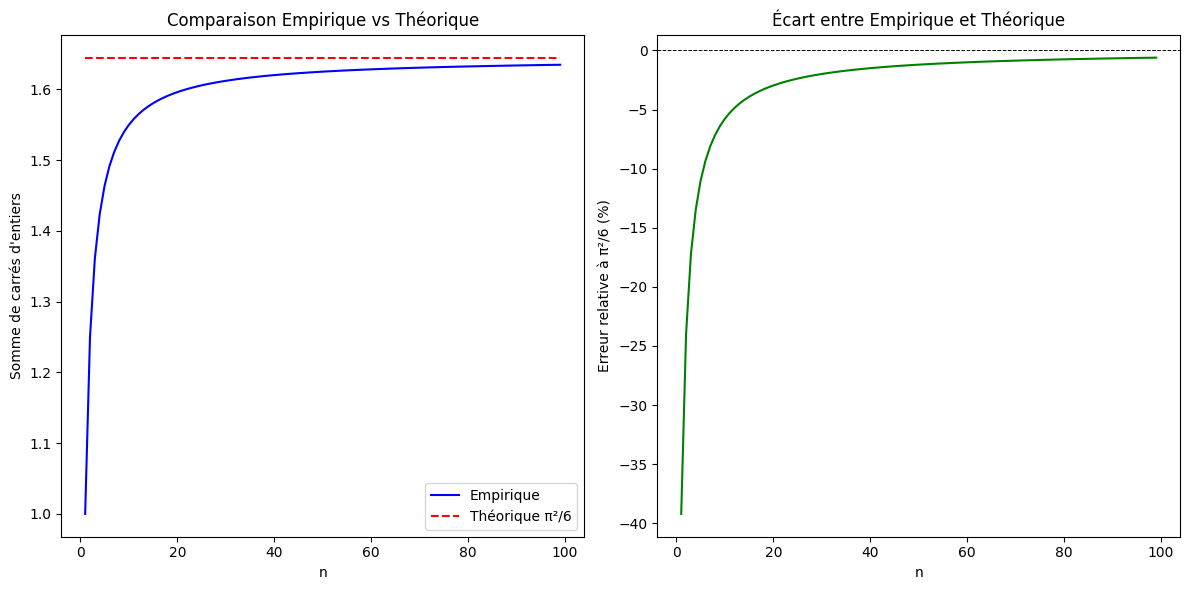

In [9]:
import math
import matplotlib.pyplot as plt

def count_coprime_pairs(n):
    """Calcule le nombre de couples (a, b) avec pgcd(a, b) = 1 et a, b <= n."""
    count = 0
    for a in range(1, n + 1):
        for b in range(1, n + 1):
            if math.gcd(a, b) == 1:
                count += 1
    return count

def theoretical_count(n):
    """Retourne l'estimation théorique (6/pi²) * n²."""
    return (6 / math.pi**2) * n**2

def euler(n) :
    if n == 1 : return 1
    else : return (1/n)**2 + euler(n-1)

# Test pour différentes valeurs de n
n_values = list(range(1, 100))  # De 1 à 100
empirical_counts = [count_coprime_pairs(n) for n in n_values]
theoretical_counts = [theoretical_count(n) for n in n_values]

empirical_counts1 = [euler(n) for n in n_values]
theoretical_value = (math.pi**2)/6

# Calcul de l'erreur relative (%)
relative_errors = [
    (empirical - theoretical) / theoretical * 100
    for empirical, theoretical in zip(empirical_counts, theoretical_counts)
]

relative_errors1 = [
    (empirical - theoretical_value) / theoretical_value * 100
    for empirical in empirical_counts1
]

# Visualisation
plt.figure(figsize=(12, 6))

# # Comparaison des comptes empiriques et théoriques
# plt.subplot(1, 2, 1)
# plt.plot(n_values, empirical_counts, label="Empirique", color="blue")
# plt.plot(n_values, theoretical_counts, label="Théorique (6/π² × n²)", linestyle="--", color="red")
# plt.xlabel("n")
# plt.ylabel("Nombre de couples premiers entre eux")
# plt.title("Comparaison Empirique vs Théorique")
# plt.legend()

# # Erreur relative (%)
# plt.subplot(1, 2, 2)
# plt.plot(n_values, relative_errors, color="green")
# plt.xlabel("n")
# plt.ylabel("Erreur relative (%)")
# plt.title("Écart entre Empirique et Théorique")
# plt.axhline(y=0, color="black", linestyle="--", linewidth=0.7)

 # Comparaison des comptes empiriques et théoriques
plt.subplot(1, 2, 1)
plt.plot(n_values, empirical_counts1, label="Empirique", color="blue")
plt.plot(n_values, [theoretical_value]*len(n_values), label="Théorique π²/6", linestyle="--", color="red")
plt.xlabel("n")
plt.ylabel("Somme de carrés d'entiers")
plt.title("Comparaison Empirique vs Théorique")
plt.legend()

# Erreur relative (%)
plt.subplot(1, 2, 2)
plt.plot(n_values, relative_errors1, color="green")
plt.xlabel("n")
plt.ylabel("Erreur relative à π²/6 (%)")
plt.title("Écart entre Empirique et Théorique")
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------------------------------------------
# IAQ Dashboard – courbes brutes, colonnes numériques dynamiques
#   • pas d’agrégation temporelle
#   • concaténation robuste même si les colonnes diffèrent
#   • color_picker par trace mémorisé dans st.session_state
# ---------------------------------------------------------------
import io, streamlit as st, polars as pl, plotly.graph_objects as go
from plotly_resampler import FigureResampler
from dateutil import parser
from plotly.subplots import make_subplots
import pandas as pd  


st.set_page_config(page_title="Ecozimut", layout="wide")

# ─────────────────── Fonctions utilitaires ────────────────────
def fallback_parse(ts: str):
    """Essaie de parser n’importe quel timestamp texte → datetime."""
    try:
        return parser.parse(ts, dayfirst=True)
    except Exception:
        return None

def load_file(up) -> pl.DataFrame | None:
    """Lit un fichier CSV/XLSX, renvoie un DF avec datetime, sensor, + colonnes numériques."""
    raw = up.read()
    is_xls = up.name.lower().endswith((".xls", ".xlsx"))
    sep = ";" if (not is_xls and b";" in raw.splitlines()[0]) else ","

    try:
        if is_xls:
            # utiliser pandas pour lister les feuilles
            excel = pd.ExcelFile(io.BytesIO(raw))
            if not excel.sheet_names:
                st.error(f"{up.name} : aucune feuille Excel détectée.")
                return None
            # lire la première feuille valide avec pandas puis convertir en polars
            pdf = excel.parse(sheet_name=excel.sheet_names[0])
            df = pl.from_pandas(pdf)
        else:
            df = pl.read_csv(io.BytesIO(raw), separator=sep, encoding="latin1",
                             truncate_ragged_lines=True)
    except Exception as e:
        st.error(f"Erreur lors de la lecture de {up.name} : {e}")
        return None

    # Nettoyage des noms de colonnes (en minuscules sans espaces)
    df = df.rename({col: col.strip().lower().replace(" ", "") for col in df.columns})
    cols = set(df.columns)

    # Fusion date + heure
    if {"date", "h"}.issubset(cols):
        df = df.with_columns(
            (pl.col("date").cast(pl.Utf8) + " " + pl.col("h").cast(pl.Utf8)).alias("datetime")
        )
    elif "date" in cols:
        df = df.rename({"date": "datetime"})
    else:
        st.error(f"{up.name} → colonnes 'date' (et optionnel 'h') introuvables.")
        return None

    # Parsing robuste du datetime
    dt = pl.coalesce([
        pl.col("datetime").str.strptime(pl.Datetime, "%d/%m/%Y %H:%M:%S", strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%d/%m/%Y %H:%M", strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S", strict=False),
        pl.col("datetime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M", strict=False),
        pl.col("datetime").map_elements(fallback_parse, return_dtype=pl.Datetime)
    ])

    df = df.with_columns(dt.alias("datetime")).drop_nulls("datetime")

    # Conversion automatique des colonnes numériques
    reserved = {"datetime", "date", "h"}
    numeric_cols = []
    for c in df.columns:
        if c in reserved:
            continue
        try:
            df = df.with_columns(
                pl.col(c).cast(pl.Utf8).str.replace(",", ".").cast(pl.Float64, strict=False)
            )
            if df[c].null_count() < df.height:
                numeric_cols.append(c)
        except Exception:
            continue

    if not numeric_cols:
        st.error(f"{up.name} → aucune colonne numérique détectée.")
        return None

    return df.select(["datetime"] + numeric_cols).with_columns(
        pl.lit(up.name).alias("sensor")
    )


def detect_outliers_iqr(df: pl.DataFrame, column: str) -> pl.DataFrame:
    """Détecte les valeurs aberrantes dans une colonne en utilisant la méthode IQR."""
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    return df.with_columns(
        pl.col(column).apply(lambda x: x < lower_bound or x > upper_bound).alias(f"is_outlier_{column}")
    )

def display_descriptive_statistics(df: pl.DataFrame, columns: list[str]):
    """Affiche les statistiques descriptives pour les colonnes spécifiées, avec et sans outliers."""
    if not columns:
        st.info("Sélectionnez des variables pour afficher les statistiques descriptives.")
        return

    st.subheader("Statistiques descriptives")
    stats_data = []
    for col in columns:
        if col in df.columns and df[col].dtype.is_numeric():
            series = df[col]
            stats = {
                "Variable": col,
                "Count": series.count(),
                "Mean": series.mean(),
                "Std Dev": series.std(),
                "Min": series.min(),
                "25%": series.quantile(0.25),
                "50% (Median)": series.median(),
                "75%": series.quantile(0.75),
                "Max": series.max()
            }

            # Vérifie s’il existe une colonne outlier correspondante
            outlier_col = f"is_outlier_{col}"
            if outlier_col in df.columns:
                # Filtre les non-outliers et calcule leur moyenne
                non_outliers = df.filter(pl.col(outlier_col) == False)
                mean_wo_outliers = non_outliers[col].mean()
                stats["Mean (hors outliers)"] = mean_wo_outliers
            else:
                stats["Mean (hors outliers)"] = "—"

            stats_data.append(stats)

    if stats_data:
        st.dataframe(pl.DataFrame(stats_data))
    else:
        st.info("Aucune donnée numérique valide pour les statistiques descriptives.")

def display_correlation_matrix(df: pl.DataFrame, columns: list[str]):
    """Affiche la matrice de corrélation pour les colonnes spécifiées."""
    if not columns or len(columns) < 2:
        st.info("Sélectionnez au moins deux variables numériques pour afficher la matrice de corrélation.")
        return
    
    st.subheader("Matrice de corrélation")
    # Sélectionner uniquement les colonnes numériques pour la corrélation
    numeric_df = df.select([
            col for col in columns
            if df[col].dtype.is_numeric() and df[col].null_count() < df.height
        ])

    if numeric_df.width < 2:
        st.info("Aucune paire de variables numériques valide pour la corrélation.")
        return

    correlation_matrix = numeric_df.corr()
    st.dataframe(correlation_matrix)

# ─────────────────── Interface Streamlit ────────────────────
st.title("📈 Ecozimut Dashboard : Mesures des sondes  ")

uploads = st.file_uploader(
    "Déposez vos CSV / XLSX (date [+ h] + colonnes numériques) :",
    type=["csv", "xlsx", "xls"], accept_multiple_files=True)

if not uploads:
    st.stop()

frames = [d for f in uploads if (d := load_file(f)) is not None]
if not frames:
    st.stop()

# ── 1) union de toutes les colonnes numériques détectées
all_numeric = set()
for df in frames:
    all_numeric |= set(df.columns) - {"datetime", "sensor"}
all_numeric = sorted(all_numeric)       # ordre stable

# ── 2) aligner chaque DF (colonnes manquantes + cast Float64)
aligned = []
for df in frames:
    # ajouter les colonnes manquantes, typées Float64
    miss = [c for c in all_numeric if c not in df.columns]
    if miss:
        df = df.with_columns([
            pl.lit(None).cast(pl.Float64).alias(c) for c in miss
        ])
    # garantir que toutes les colonnes numériques sont Float64
    df = df.with_columns([
        pl.col(c).cast(pl.Float64, strict=False) for c in all_numeric
    ])
    aligned.append(df.select(["datetime", "sensor"] + all_numeric))


# ── 3) concaténation sans ShapeError
data = pl.concat(aligned).sort("datetime")

# Détection de la période disponible dans les données
min_date = data["datetime"].min()
max_date = data["datetime"].max()

st.sidebar.markdown("### 📅 Filtrer par date")
date_range = st.sidebar.date_input(
    "Plage de dates :", 
    value=(min_date.date(), max_date.date()),
    min_value=min_date.date(),
    max_value=max_date.date()
)

# widgets – capteurs toujours visibles, même s’ils n'ont plus de données
sensors = data["sensor"].unique().to_list()

# Gestion du filtre : tronquer les données selon la plage sélectionnée
if isinstance(date_range, tuple) and len(date_range) == 2:
    start_dt = pl.datetime(date_range[0].year, date_range[0].month, date_range[0].day, 0, 0)
    end_dt   = pl.datetime(date_range[1].year, date_range[1].month, date_range[1].day, 23, 59, 59)
    data = data.filter((pl.col("datetime") >= start_dt) & (pl.col("datetime") <= end_dt))



# widgets
sensors = data["sensor"].unique().to_list()
sel_sensors = st.sidebar.multiselect("Sondes :", sensors, default=sensors)



vars_ = st.sidebar.multiselect("Variables :", all_numeric, default=[])

# on ne gère pour l’instant que deux variables avec axes distincts
if len(vars_) > 2:
    st.sidebar.warning("⚠️ L’outil affiche au maximum 2 variables simultanées.")
    vars_ = vars_[:2]


plot_df = data.filter(pl.col("sensor").is_in(sel_sensors))

# Section pour les analyses
with st.expander("📊 Analyses des données", expanded=True):
    # Détection des valeurs aberrantes
    if st.checkbox("Activer la détection des valeurs aberrantes (IQR)"):
        outliers_df = pl.DataFrame()
        for var in vars_:
            plot_df = detect_outliers_iqr(plot_df, var)
            outliers_for_var = plot_df.filter(pl.col(f"is_outlier_{var}") == True)
            if not outliers_for_var.is_empty():
                outliers_df = (
                    pl.concat([outliers_df, outliers_for_var], how="diagonal")
                    if outliers_df.height > 0
                    else outliers_for_var
                )

        
        if not outliers_df.is_empty():
            st.subheader("Valeurs aberrantes détectées")
            st.dataframe(outliers_df.select(["datetime", "sensor"] + vars_ + [f"is_outlier_{v}" for v in vars_ if f"is_outlier_{v}" in outliers_df.columns]))
        else:
            st.info("Aucune valeur aberrante détectée pour les variables sélectionnées.")

    # Statistiques descriptives
    display_descriptive_statistics(plot_df, vars_)

    # Matrice de corrélation
    display_correlation_matrix(plot_df, vars_)


# ── réglages d’échelle pour chaque variable sélectionnée
y_ranges = {}
with st.sidebar.expander("🔧 Ajuster les échelles (min / max)", expanded=False):
    for v in vars_:
        col1, col2 = st.columns(2)
        v_min = float(plot_df[v].min())
        v_max = float(plot_df[v].max())
        with col1:
            min_val = st.number_input(f"{v} min", value=v_min, key=f"{v}_min")
        with col2:
            max_val = st.number_input(f"{v} max", value=v_max, key=f"{v}_max")
        # sécurité : si l’utilisateur met min >= max on ignore la saisie
        y_ranges[v] = None if min_val >= max_val else [min_val, max_val]


# ── palette + color_picker mémorisés
if "color_map" not in st.session_state:
    st.session_state.color_map = {}

default_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
                   "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
                   "#17becf", "#bcbd22"]

with st.sidebar.expander("🎨 Couleurs", expanded=False):
    idx = 0
    for v in vars_:
        for s in sel_sensors:
            key = f"{s} – {v}"
            st.session_state.color_map[key] = st.color_picker(
                key,
                value=st.session_state.color_map.get(
                    key, default_palette[idx % len(default_palette)]
                )
            )
            idx += 1

# ── Alertes et Seuils
thresholds = {}
with st.sidebar.expander("🚨 Alertes et Seuils", expanded=False):
    for v in vars_:
        st.write(f"**{v}**")
        col1, col2 = st.columns(2)
        with col1:
            min_threshold = st.number_input(f"Seuil min {v}", key=f"threshold_min_{v}", value=None)
        with col2:
            max_threshold = st.number_input(f"Seuil max {v}", key=f"threshold_max_{v}", value=None)
        thresholds[v] = {"min": min_threshold, "max": max_threshold}


# ────────── Tracé avec axes distincts (gauche/droite) ──────────
fig = make_subplots(specs=[[{"secondary_y": len(vars_) == 2}]])

for idx, v in enumerate(vars_):
    secondary = True if idx == 1 else False   # 2ᵉ variable -> axe droit
    for s in sel_sensors:
        sub = plot_df.filter(pl.col("sensor") == s)
        if sub[v].null_count() == sub.height:
            continue
        trace_name = f"{s} – {v}"
        
        # Ajouter la trace principale
        fig.add_trace(
            go.Scattergl(
                x=sub["datetime"],
                y=sub[v],
                name=trace_name,
                mode="lines",
                line=dict(color=st.session_state.color_map[trace_name])
            ),
            secondary_y=secondary
        )
        
        # Ajouter les valeurs aberrantes si la détection est activée
        if f"is_outlier_{v}" in sub.columns:
            outliers_sub = sub.filter(pl.col(f"is_outlier_{v}") == True)
            if not outliers_sub.is_empty():
                fig.add_trace(
                    go.Scattergl(
                        x=outliers_sub["datetime"],
                        y=outliers_sub[v],
                        name=f"Outliers {trace_name}",
                        mode="markers",
                        marker=dict(color="red", size=8, symbol="x")
                    ),
                    secondary_y=secondary
                )
        
        # Ajouter les seuils et les points de dépassement
        min_thresh = thresholds[v]["min"]
        max_thresh = thresholds[v]["max"]

        if min_thresh is not None:
            fig.add_hline(y=min_thresh, line_dash="dot", line_color="orange", 
                          annotation_text=f"Seuil min {v}", annotation_position="bottom right", secondary_y=secondary)
            # Highlight points below min threshold
            below_min = sub.filter(pl.col(v) < min_thresh)
            if not below_min.is_empty():
                fig.add_trace(
                    go.Scattergl(
                        x=below_min["datetime"],
                        y=below_min[v],
                        name=f"Sous seuil min {trace_name}",
                        mode="markers",
                        marker=dict(color="orange", size=8, symbol="circle")
                    ),
                    secondary_y=secondary
                )

        if max_thresh is not None:
            fig.add_hline(y=max_thresh, line_dash="dot", line_color="purple", 
                          annotation_text=f"Seuil max {v}", annotation_position="top right", secondary_y=secondary)
            # Highlight points above max threshold
            above_max = sub.filter(pl.col(v) > max_thresh)
            if not above_max.is_empty():
                fig.add_trace(
                    go.Scattergl(
                        x=above_max["datetime"],
                        y=above_max[v],
                        name=f"Au-dessus seuil max {trace_name}",
                        mode="markers",
                        marker=dict(color="purple", size=8, symbol="circle")
                    ),
                    secondary_y=secondary
                )

if len(vars_) == 1:
    fig.update_yaxes(title_text=vars_[0])
elif len(vars_) == 2:
    fig.update_yaxes(title_text=vars_[0], secondary_y=False)
    fig.update_yaxes(title_text=vars_[1], secondary_y=True)
else:
    pass

# appliquer les limites min/max si fournies
for idx, v in enumerate(vars_):
    rng = y_ranges.get(v)
    if rng:
        fig.update_yaxes(range=rng, secondary_y=(idx == 1) if len(vars_) == 2 else False)

fig.update_layout(
    title="Courbes brutes",
    height=600,
    xaxis_title="Date/heure",
    legend=dict(
        orientation="v",         # Légende horizontale
        yanchor="bottom",
        y=1.02,                  # Légèrement au-dessus du graphe
        xanchor="right",
        x=1                      # Alignée à droite
    )
)


#st.plotly_chart(FigureResampler(fig), use_container_width=True)
st.plotly_chart(fig, use_container_width=True)


# ── Export CSV brut
st.download_button("Télécharger CSV concaténé",
                   data=data.write_csv(), file_name="mesures_brutes.csv")


